In [4]:
from Load import *
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from itertools import product
import pickle

In [5]:
# base_name -> [heights, Transform]
Height = {}
for base_name in data:
    Height[base_name] = [data[base_name][1][0]-data[base_name][0][0], data[base_name][0][1]]

## Stats Distribution

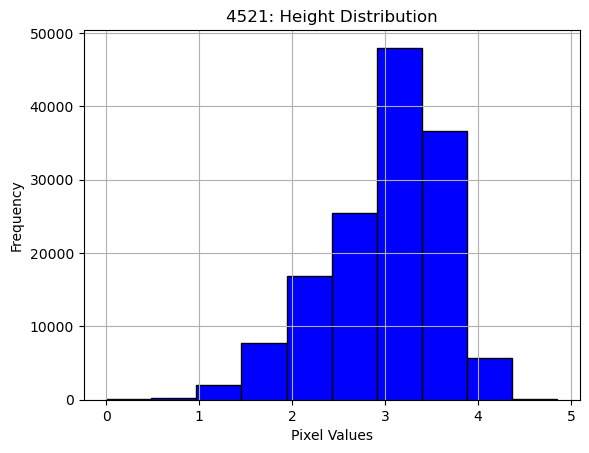

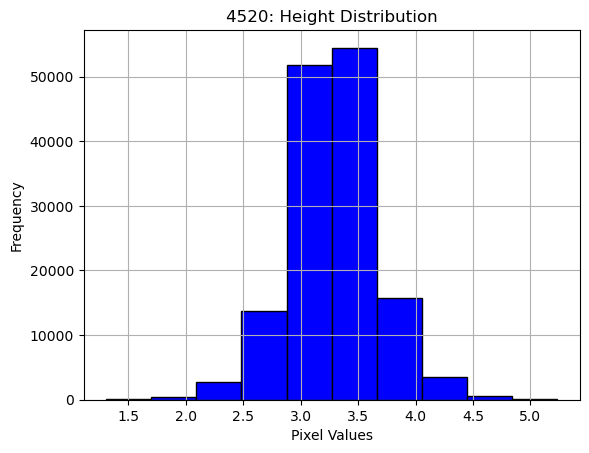

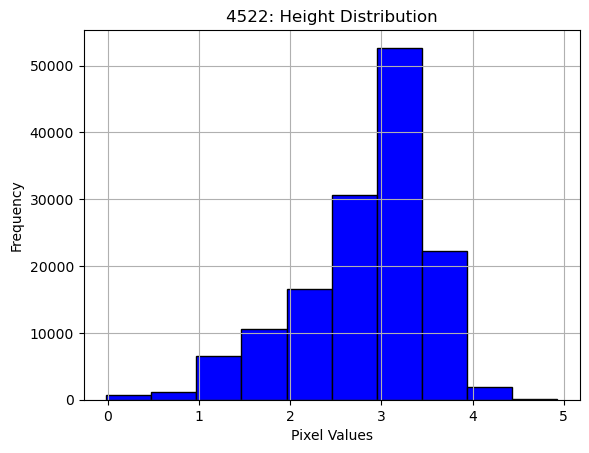

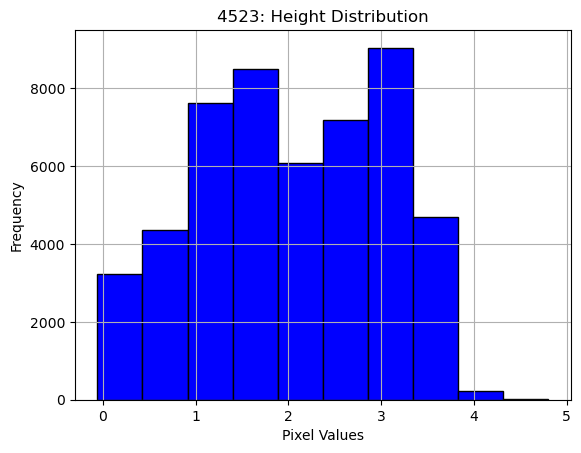

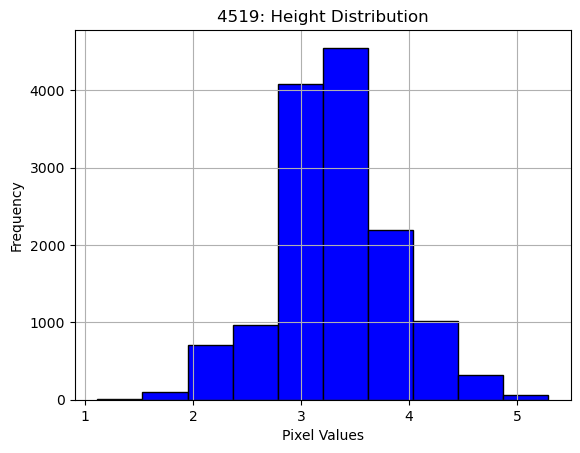

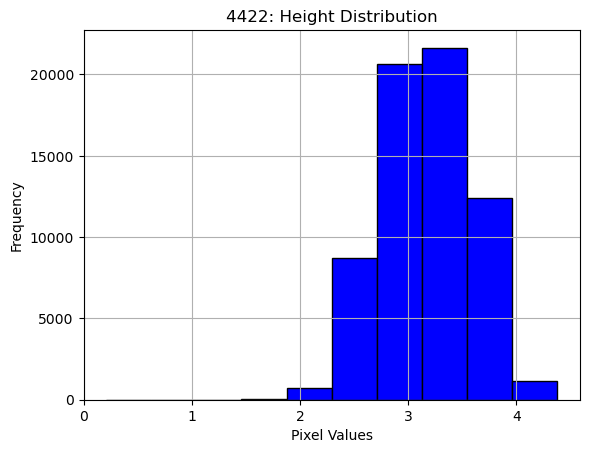

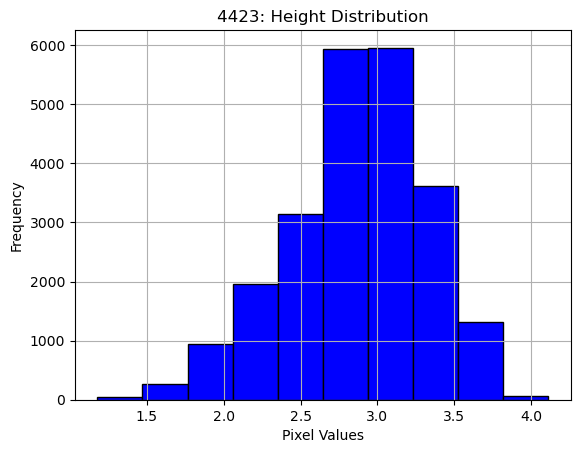

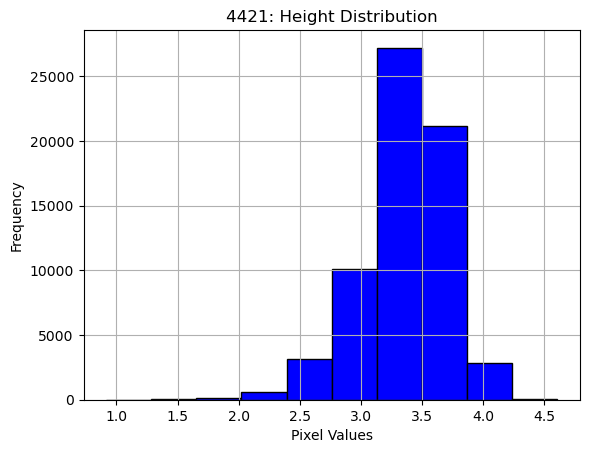

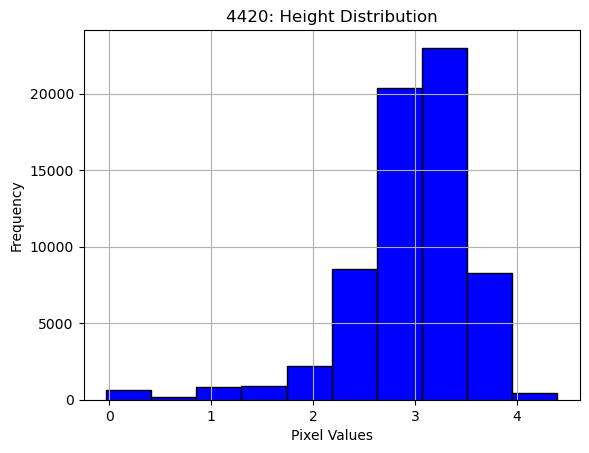

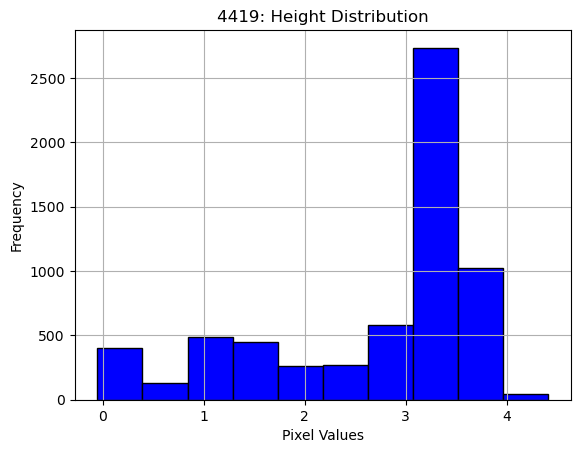

In [3]:
def ht_dist(base_name, bins=10):
    flattened_data = Height[base_name][0].flatten()
    plt.hist(flattened_data, bins=bins, color='blue', edgecolor='black')
    plt.title(f"{base_name}: Height Distribution")
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

for base_name in Height:
    ht_dist(base_name)

## CNN

In [10]:
# 0. Prep data
def make_data(n, side): # num of random crops, side len in m=px of height image cropped
    # each element [X (cropped from aerial), Y (cropped from Height)] is a train-test sample
    mangrove_data = []
    for base_name in Height:
        x_lim = Height[base_name][0].shape[1]-side
        y_lim = Height[base_name][0].shape[0]-side
        
        for i in range(n):
            # sometimes random point falls outside the boundary because aerial photo doesn't cover all DEM-DSM image
            while True:
                try:
                    x = random.randint(0, x_lim)
                    y = random.randint(0, y_lim)
                    Height_window, aer_window = overlap(base_name, x, y, side)
                    break
                except:
                    pass
            aer_crop = crop(aer_data[0], aer_window)
            hei_crop = crop(Height[base_name][0], Height_window)
            mangrove_data.append([aer_crop, hei_crop])
            
    X = torch.tensor([sample[0] for sample in mangrove_data], dtype=torch.float32)
    Y = torch.tensor([sample[1] for sample in mangrove_data], dtype=torch.float32)
    # Normalize X (aerial image) between 0 and 1
    X /= 255.0
    # Reshape Y to be compatible (batch, channels, height, width)
    Y = Y.unsqueeze(1)  # Add channel dimension (since it's a single-channel height image)
    return X, Y

In [12]:
# 1. Train-test split
def Train_test_split(X, Y):
    train_size = int(0.8 * len(X))
    test_size = len(X) - train_size
    train_dataset, test_dataset = random_split(TensorDataset(X, Y), [train_size, test_size])
    
    # Create DataLoader for batching
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_loader, test_loader

In [14]:
# 2. Build CNN Model
class MangroveHeightCNN(nn.Module):
    def __init__(self, kernel_size1, kernel_size2, stride, side, w=0.7):
        padding1 = (kernel_size1-1)//2
        padding2 = (kernel_size2-1)//2
        self.side = side
        conv1_size = ((side//0.3-1)//stride+1)//2
        conv2_size = ((conv1_size-1)//stride+1)//2
        conv3_size = int(((conv2_size-1)//stride+1)//2)
        fc1_size = 64*conv3_size*conv3_size
        fc2_size = int(fc1_size**(1-w) * self.side**(2*w)) # weighted geometric mean

        super(MangroveHeightCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=kernel_size1, stride=stride, padding=padding1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size2, stride=stride, padding=padding2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel_size2, stride=stride, padding=padding2)
        self.fc1 = nn.Linear(fc1_size, fc2_size)
        self.fc2 = nn.Linear(fc2_size, self.side**2)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten into (batch_size, feature_size)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 1, self.side, self.side)  # Reshape output to (batch_size, channels, height, width)

In [16]:
# 3. Train CNN
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    train_losses = []
    test_losses = []
    central_pixel_losses = []
    central_pixel_index = side//2
    
    for epoch in range(epochs):
        # Training
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        # test
        model.eval()  # Set model to evaluation mode
        running_test_loss = 0.0
        running_central_pixel_loss = 0.0
        
        with torch.no_grad():  # No gradient computation in evaluation mode
            for test_inputs, test_targets in test_loader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_targets)
                running_test_loss += test_loss.item()

                # difference between the central pixel predictions and ground truth
                predicted_central_pixel = test_outputs[:, 0, central_pixel_index, central_pixel_index]
                target_central_pixel = test_targets[:, 0, central_pixel_index, central_pixel_index]
                central_pixel_loss = torch.abs(predicted_central_pixel - target_central_pixel).mean().item()
                running_central_pixel_loss += central_pixel_loss

        avg_test_loss = running_test_loss/len(test_loader)
        test_losses.append(avg_test_loss)
        
        avg_central_pixel_loss = running_central_pixel_loss/len(test_loader)
        central_pixel_losses.append(avg_central_pixel_loss)
    
    return np.array(train_losses), np.array(test_losses), np.array(central_pixel_losses)

In [ ]:
# Define the parameter
n = 200
sides = [6, 9, 12, 15, 18]
kernel_sizes1 = [3, 5]
kernel_sizes2 = [3, 5]
strides = [1, 2]
repeat = 4 # to average for each model setting

errors = dict()
for j in range(repeat):
    # Run CNN for each combination of parameters
    for side, kernel_size1, kernel_size2, stride in product(sides, kernel_sizes1, kernel_sizes2, strides):
        X, Y = make_data(n, side)
        train_loader, test_loader = Train_test_split(X, Y)
        model = MangroveHeightCNN(kernel_size1, kernel_size2, stride, side)
        criterion = nn.MSELoss()  # for regression task
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        try:
            train_losses, test_losses, central_pixel_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)
            if (side, kernel_size1, kernel_size2, stride) not in errors:
                errors[(side, kernel_size1, kernel_size2, stride)] = [[train_losses], [test_losses], [central_pixel_losses]]
            else:
                err = errors[(side, kernel_size1, kernel_size2, stride)] # list of errors of this param
                err[0].append(train_losses)
                err[1].append(test_losses)
                err[2].append(central_pixel_losses)
        except: # stride=2 not permissible for some input sizes of model
            pass

for params in errors:
    side, kernel_size1, kernel_size2, stride = params
    err = errors[(side, kernel_size1, kernel_size2, stride)]
    err[0] = np.mean(err[0], axis=0)
    err[1] = np.mean(err[1], axis=0)
    err[2] = np.mean(err[2], axis=0)

with open("errors.pkl", "wb") as f:
    pickle.dump(errors, f)

side = 6, kernel_size1 = 3, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 3.2932, test MSE: 0.6428, central pixel MAE: 0.5591
Epoch 2/5, train MSE: 0.5816, test MSE: 0.5942, central pixel MAE: 0.5757
Epoch 3/5, train MSE: 0.5747, test MSE: 0.5855, central pixel MAE: 0.5776
Epoch 4/5, train MSE: 0.5711, test MSE: 0.5650, central pixel MAE: 0.5617
Epoch 5/5, train MSE: 0.5663, test MSE: 0.6414, central pixel MAE: 0.6216


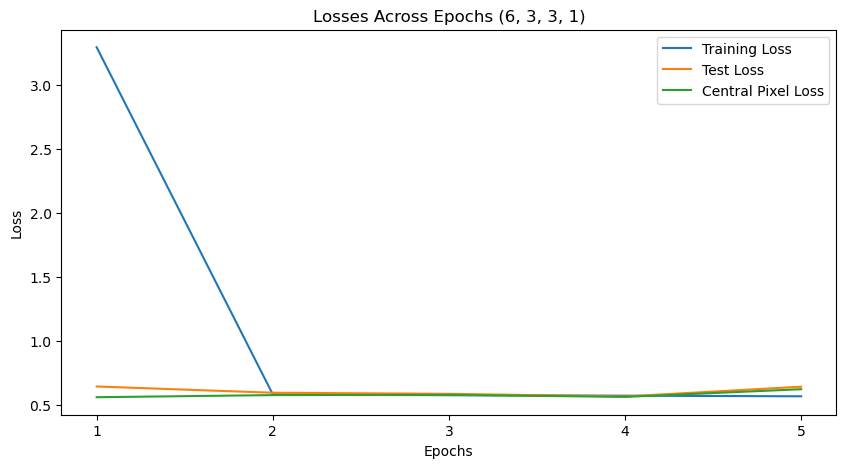

side = 6, kernel_size1 = 3, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 2.7208, test MSE: 0.6032, central pixel MAE: 0.5541
Epoch 2/5, train MSE: 0.5948, test MSE: 0.5738, central pixel MAE: 0.5592
Epoch 3/5, train MSE: 0.5699, test MSE: 0.5298, central pixel MAE: 0.5373
Epoch 4/5, train MSE: 0.5494, test MSE: 0.5755, central pixel MAE: 0.5314
Epoch 5/5, train MSE: 0.5405, test MSE: 0.5764, central pixel MAE: 0.5716


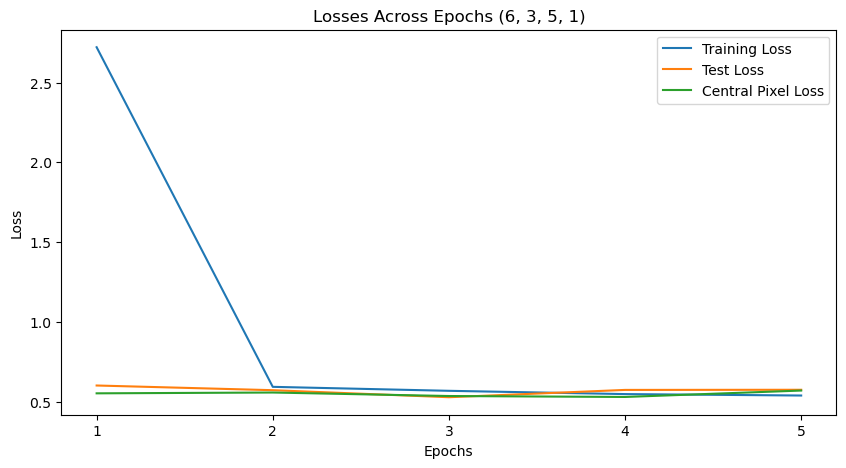

side = 6, kernel_size1 = 5, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 3.1175, test MSE: 0.6193, central pixel MAE: 0.5512
Epoch 2/5, train MSE: 0.6334, test MSE: 0.5754, central pixel MAE: 0.5642
Epoch 3/5, train MSE: 0.6030, test MSE: 0.5642, central pixel MAE: 0.5724
Epoch 4/5, train MSE: 0.6158, test MSE: 0.5815, central pixel MAE: 0.5976
Epoch 5/5, train MSE: 0.5976, test MSE: 0.5327, central pixel MAE: 0.5258


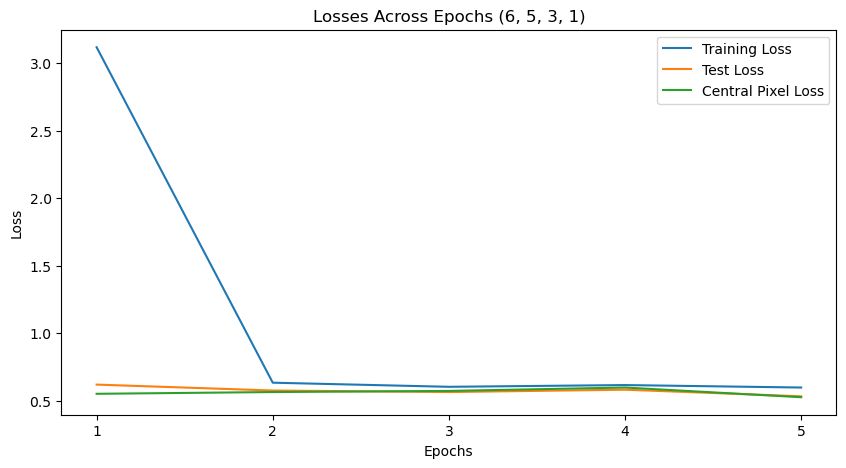

side = 6, kernel_size1 = 5, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 2.7072, test MSE: 0.6476, central pixel MAE: 0.6236
Epoch 2/5, train MSE: 0.5941, test MSE: 0.5920, central pixel MAE: 0.5873
Epoch 3/5, train MSE: 0.5772, test MSE: 0.5737, central pixel MAE: 0.5309
Epoch 4/5, train MSE: 0.5588, test MSE: 0.5449, central pixel MAE: 0.5444
Epoch 5/5, train MSE: 0.5693, test MSE: 0.5589, central pixel MAE: 0.5137


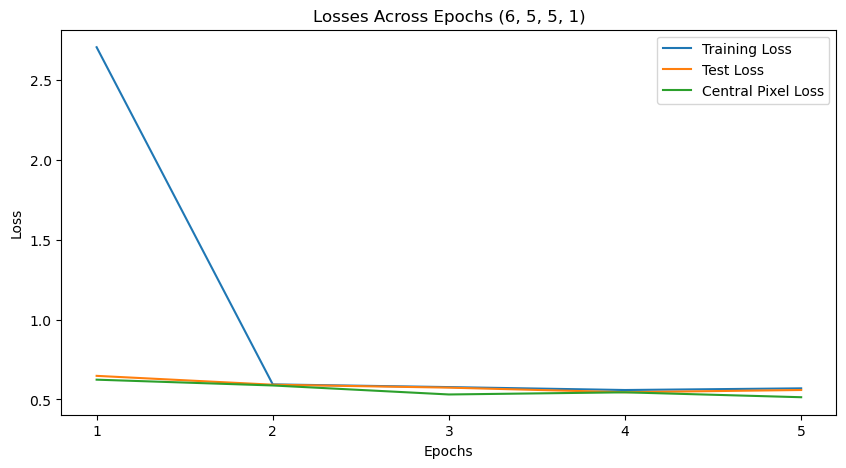

side = 9, kernel_size1 = 3, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 2.6325, test MSE: 0.5425, central pixel MAE: 0.5319
Epoch 2/5, train MSE: 0.5793, test MSE: 0.5277, central pixel MAE: 0.5302
Epoch 3/5, train MSE: 0.5637, test MSE: 0.5226, central pixel MAE: 0.5039
Epoch 4/5, train MSE: 0.5542, test MSE: 0.5027, central pixel MAE: 0.5568
Epoch 5/5, train MSE: 0.5517, test MSE: 0.4906, central pixel MAE: 0.5169


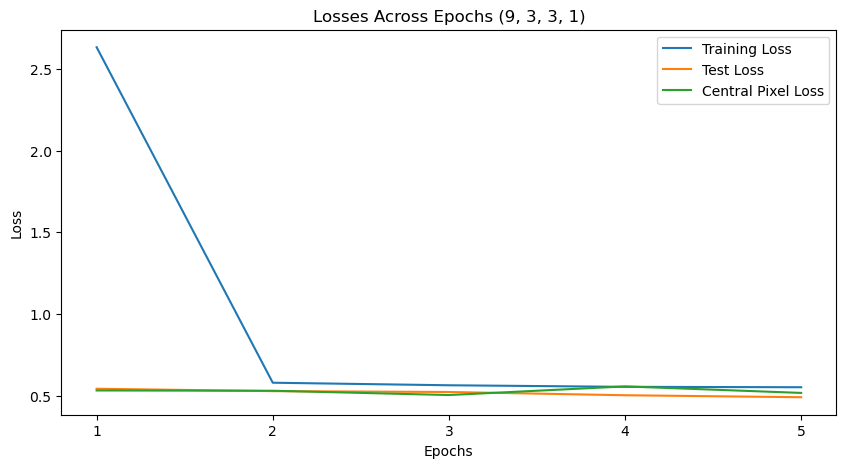

side = 9, kernel_size1 = 3, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 2.0836, test MSE: 0.6063, central pixel MAE: 0.5692
Epoch 2/5, train MSE: 0.5863, test MSE: 0.5679, central pixel MAE: 0.5747
Epoch 3/5, train MSE: 0.5789, test MSE: 0.6157, central pixel MAE: 0.5947
Epoch 4/5, train MSE: 0.5766, test MSE: 0.5253, central pixel MAE: 0.5393
Epoch 5/5, train MSE: 0.5288, test MSE: 0.5269, central pixel MAE: 0.4905


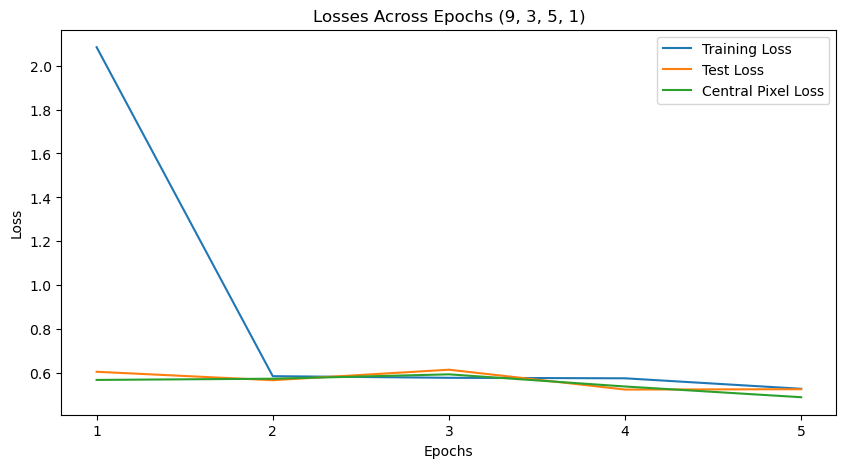

side = 9, kernel_size1 = 5, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 2.6654, test MSE: 0.6206, central pixel MAE: 0.6508
Epoch 2/5, train MSE: 0.5909, test MSE: 0.5583, central pixel MAE: 0.5601
Epoch 3/5, train MSE: 0.5764, test MSE: 0.5454, central pixel MAE: 0.5394
Epoch 4/5, train MSE: 0.5748, test MSE: 0.5518, central pixel MAE: 0.5405
Epoch 5/5, train MSE: 0.5625, test MSE: 0.5978, central pixel MAE: 0.5652


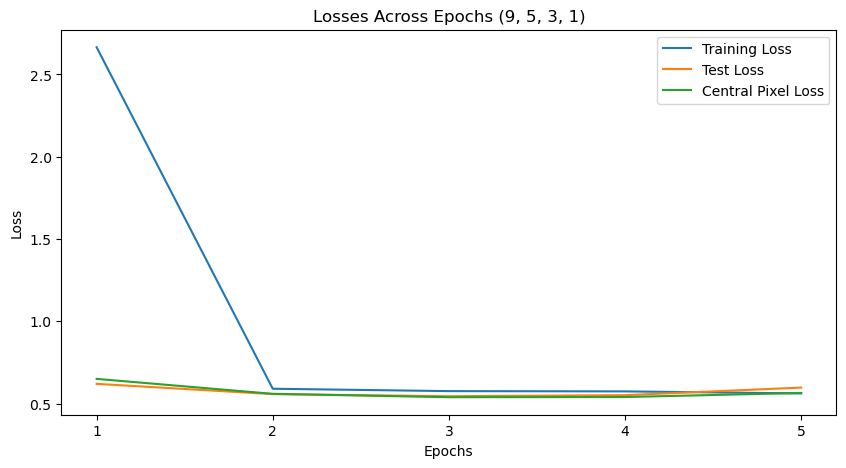

side = 9, kernel_size1 = 5, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 2.1262, test MSE: 0.6938, central pixel MAE: 0.6706
Epoch 2/5, train MSE: 0.6344, test MSE: 0.6259, central pixel MAE: 0.6076
Epoch 3/5, train MSE: 0.6274, test MSE: 0.6256, central pixel MAE: 0.5488
Epoch 4/5, train MSE: 0.6055, test MSE: 0.6348, central pixel MAE: 0.6583
Epoch 5/5, train MSE: 0.5947, test MSE: 0.5919, central pixel MAE: 0.5442


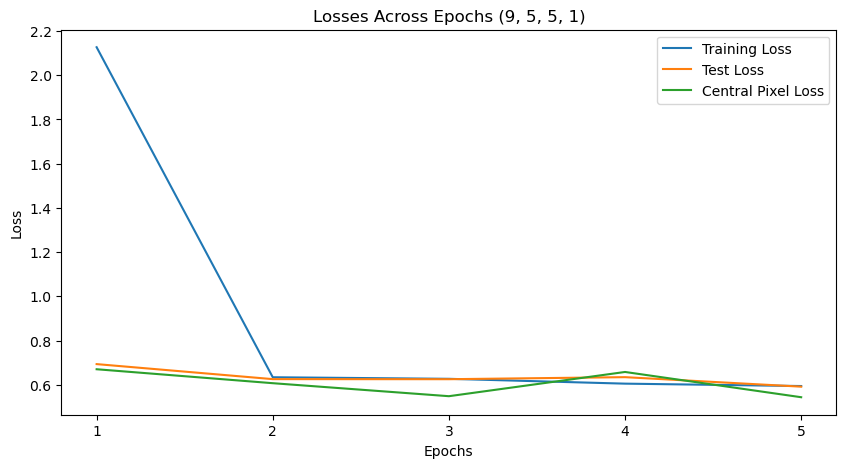

side = 12, kernel_size1 = 3, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 2.0456, test MSE: 0.5875, central pixel MAE: 0.5322
Epoch 2/5, train MSE: 0.5770, test MSE: 0.5359, central pixel MAE: 0.5277
Epoch 3/5, train MSE: 0.5630, test MSE: 0.5505, central pixel MAE: 0.5640
Epoch 4/5, train MSE: 0.5534, test MSE: 0.5088, central pixel MAE: 0.5022
Epoch 5/5, train MSE: 0.5455, test MSE: 0.5345, central pixel MAE: 0.5612


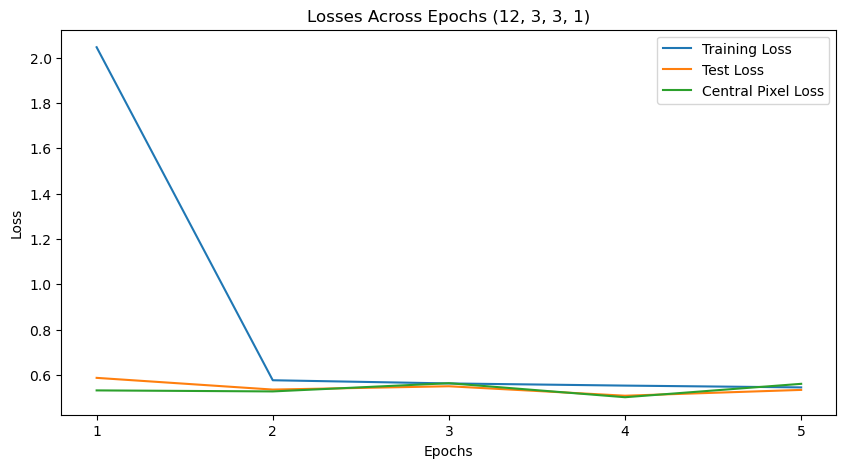

side = 12, kernel_size1 = 3, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.6796, test MSE: 0.5498, central pixel MAE: 0.5392
Epoch 2/5, train MSE: 0.5769, test MSE: 0.5571, central pixel MAE: 0.5664
Epoch 3/5, train MSE: 0.5340, test MSE: 0.5121, central pixel MAE: 0.5229
Epoch 4/5, train MSE: 0.5550, test MSE: 0.5148, central pixel MAE: 0.5161
Epoch 5/5, train MSE: 0.5443, test MSE: 0.5001, central pixel MAE: 0.4997


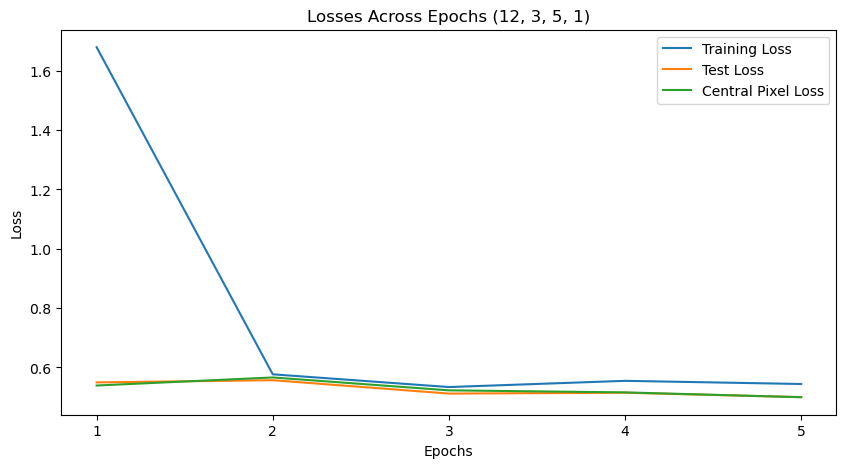

side = 12, kernel_size1 = 5, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 1.8893, test MSE: 0.6333, central pixel MAE: 0.5786
Epoch 2/5, train MSE: 0.5665, test MSE: 0.5998, central pixel MAE: 0.5846
Epoch 3/5, train MSE: 0.5605, test MSE: 0.5903, central pixel MAE: 0.5638
Epoch 4/5, train MSE: 0.5535, test MSE: 0.5518, central pixel MAE: 0.5431
Epoch 5/5, train MSE: 0.5296, test MSE: 0.5591, central pixel MAE: 0.5183


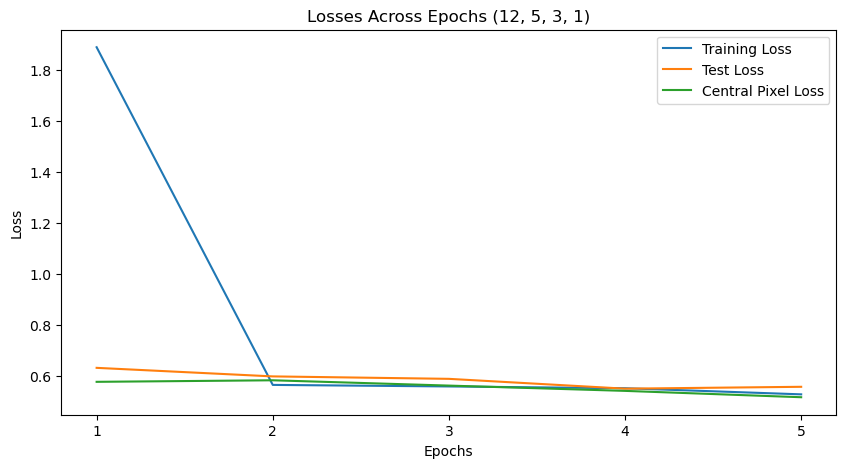

side = 12, kernel_size1 = 5, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.6929, test MSE: 0.5278, central pixel MAE: 0.5232
Epoch 2/5, train MSE: 0.6060, test MSE: 0.5246, central pixel MAE: 0.5473
Epoch 3/5, train MSE: 0.5940, test MSE: 0.4985, central pixel MAE: 0.4968
Epoch 4/5, train MSE: 0.5839, test MSE: 0.4914, central pixel MAE: 0.5154
Epoch 5/5, train MSE: 0.5912, test MSE: 0.5521, central pixel MAE: 0.5027


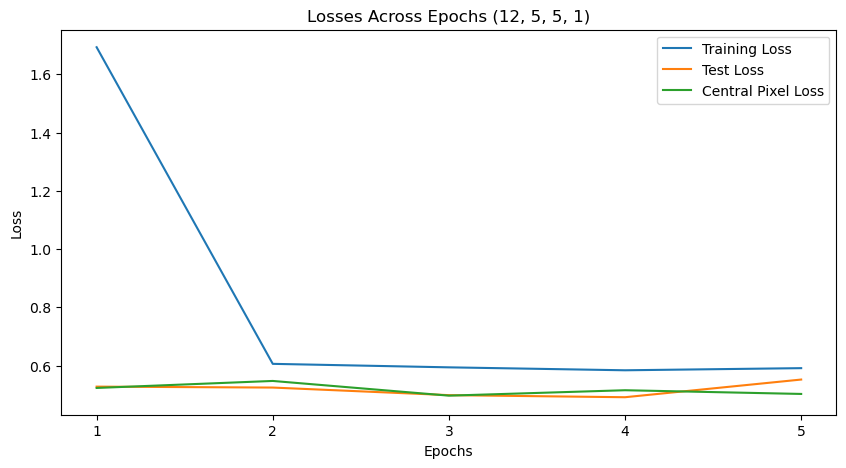

side = 15, kernel_size1 = 3, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 1.7835, test MSE: 0.5531, central pixel MAE: 0.5412
Epoch 2/5, train MSE: 0.5629, test MSE: 0.5519, central pixel MAE: 0.5735
Epoch 3/5, train MSE: 0.5579, test MSE: 0.5129, central pixel MAE: 0.5318
Epoch 4/5, train MSE: 0.5428, test MSE: 0.5087, central pixel MAE: 0.5221
Epoch 5/5, train MSE: 0.5360, test MSE: 0.5300, central pixel MAE: 0.5192


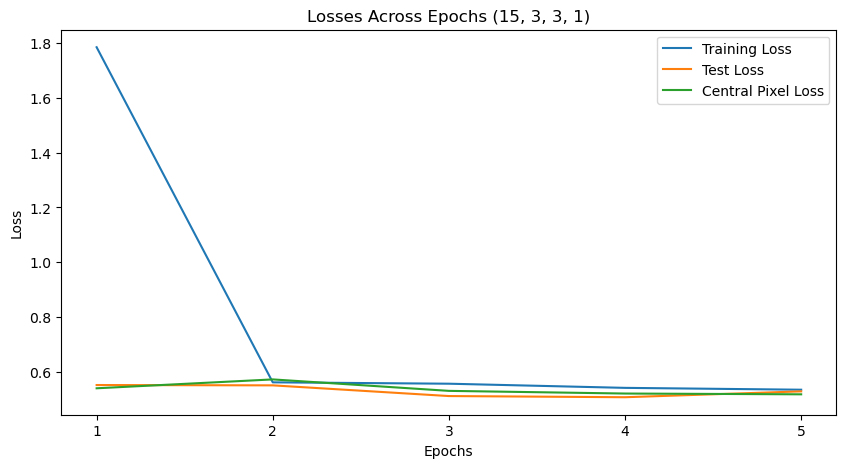

side = 15, kernel_size1 = 3, kernel_size2 = 3, stride = 2
Epoch 1/5, train MSE: 3.5882, test MSE: 0.5991, central pixel MAE: 0.5479
Epoch 2/5, train MSE: 0.5822, test MSE: 0.5517, central pixel MAE: 0.5539
Epoch 3/5, train MSE: 0.5635, test MSE: 0.5411, central pixel MAE: 0.5448
Epoch 4/5, train MSE: 0.5665, test MSE: 0.5524, central pixel MAE: 0.5310
Epoch 5/5, train MSE: 0.5519, test MSE: 0.5315, central pixel MAE: 0.5588


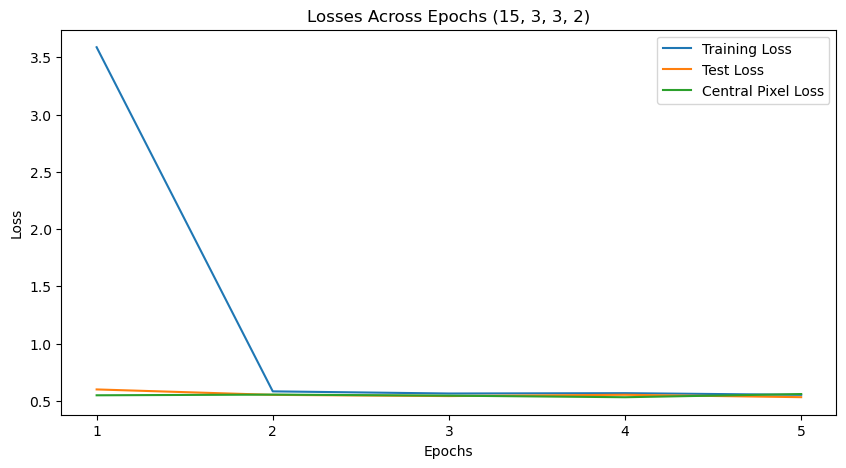

side = 15, kernel_size1 = 3, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.5881, test MSE: 0.6105, central pixel MAE: 0.5777
Epoch 2/5, train MSE: 0.5517, test MSE: 0.5577, central pixel MAE: 0.5532
Epoch 3/5, train MSE: 0.5372, test MSE: 0.5446, central pixel MAE: 0.5569
Epoch 4/5, train MSE: 0.5200, test MSE: 0.4827, central pixel MAE: 0.5179
Epoch 5/5, train MSE: 0.4890, test MSE: 0.4800, central pixel MAE: 0.5243


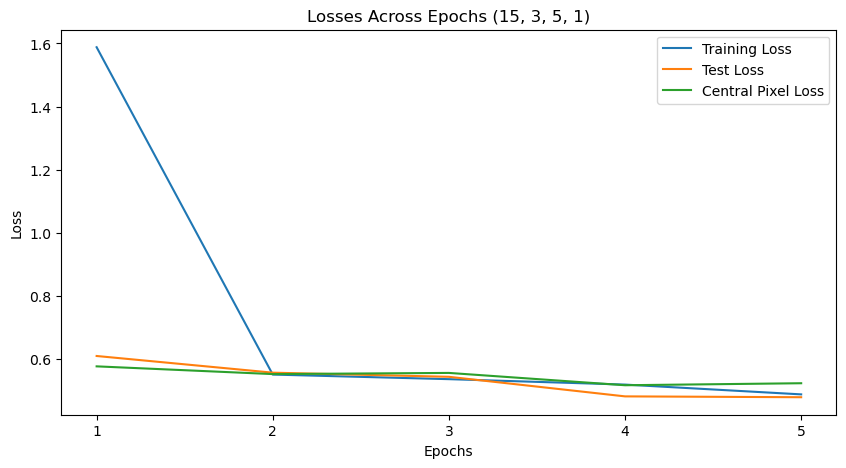

side = 15, kernel_size1 = 3, kernel_size2 = 5, stride = 2
Epoch 1/5, train MSE: 2.9121, test MSE: 0.5617, central pixel MAE: 0.5185
Epoch 2/5, train MSE: 0.5789, test MSE: 0.5242, central pixel MAE: 0.5329
Epoch 3/5, train MSE: 0.5542, test MSE: 0.5119, central pixel MAE: 0.5358
Epoch 4/5, train MSE: 0.5474, test MSE: 0.5216, central pixel MAE: 0.5147
Epoch 5/5, train MSE: 0.5388, test MSE: 0.5173, central pixel MAE: 0.5178


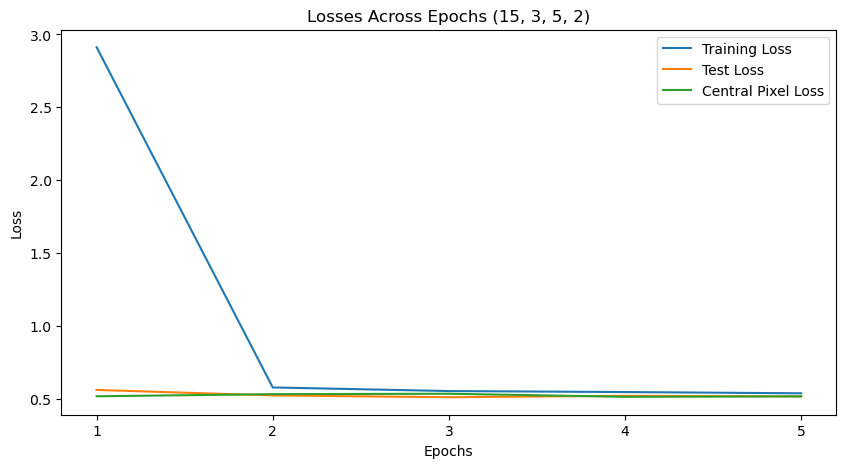

side = 15, kernel_size1 = 5, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 1.7696, test MSE: 0.5691, central pixel MAE: 0.5714
Epoch 2/5, train MSE: 0.5921, test MSE: 0.5601, central pixel MAE: 0.5556
Epoch 3/5, train MSE: 0.5777, test MSE: 0.5471, central pixel MAE: 0.5628
Epoch 4/5, train MSE: 0.5849, test MSE: 0.5517, central pixel MAE: 0.5652
Epoch 5/5, train MSE: 0.5473, test MSE: 0.5036, central pixel MAE: 0.5136


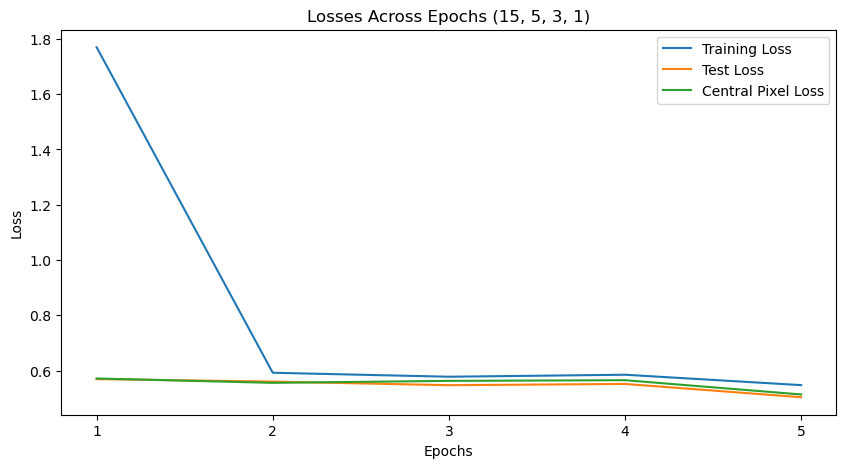

side = 15, kernel_size1 = 5, kernel_size2 = 3, stride = 2
Epoch 1/5, train MSE: 3.5745, test MSE: 0.6061, central pixel MAE: 0.5966
Epoch 2/5, train MSE: 0.5803, test MSE: 0.5470, central pixel MAE: 0.5292
Epoch 3/5, train MSE: 0.5688, test MSE: 0.5417, central pixel MAE: 0.5436
Epoch 4/5, train MSE: 0.5659, test MSE: 0.5474, central pixel MAE: 0.5211
Epoch 5/5, train MSE: 0.5621, test MSE: 0.5330, central pixel MAE: 0.5335


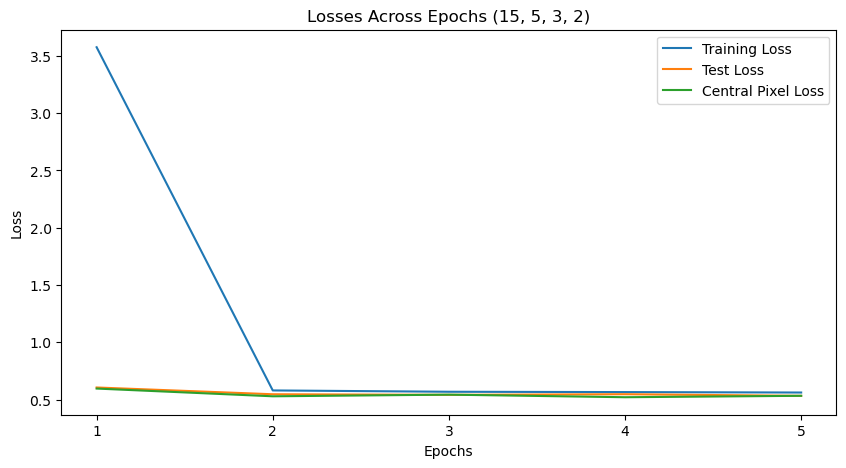

side = 15, kernel_size1 = 5, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.6906, test MSE: 0.5726, central pixel MAE: 0.5555
Epoch 2/5, train MSE: 0.6027, test MSE: 0.6597, central pixel MAE: 0.6150
Epoch 3/5, train MSE: 0.5835, test MSE: 0.5294, central pixel MAE: 0.5358
Epoch 4/5, train MSE: 0.5898, test MSE: 0.5964, central pixel MAE: 0.5391
Epoch 5/5, train MSE: 0.5701, test MSE: 0.5052, central pixel MAE: 0.5078


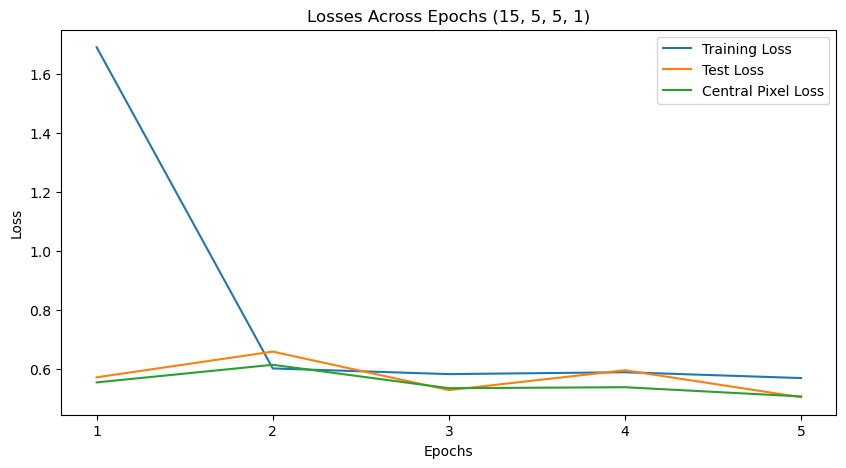

side = 15, kernel_size1 = 5, kernel_size2 = 5, stride = 2
Epoch 1/5, train MSE: 2.7383, test MSE: 0.5628, central pixel MAE: 0.5337
Epoch 2/5, train MSE: 0.5728, test MSE: 0.5424, central pixel MAE: 0.5381
Epoch 3/5, train MSE: 0.5627, test MSE: 0.5360, central pixel MAE: 0.5352
Epoch 4/5, train MSE: 0.5665, test MSE: 0.5802, central pixel MAE: 0.5209
Epoch 5/5, train MSE: 0.5589, test MSE: 0.5947, central pixel MAE: 0.5934


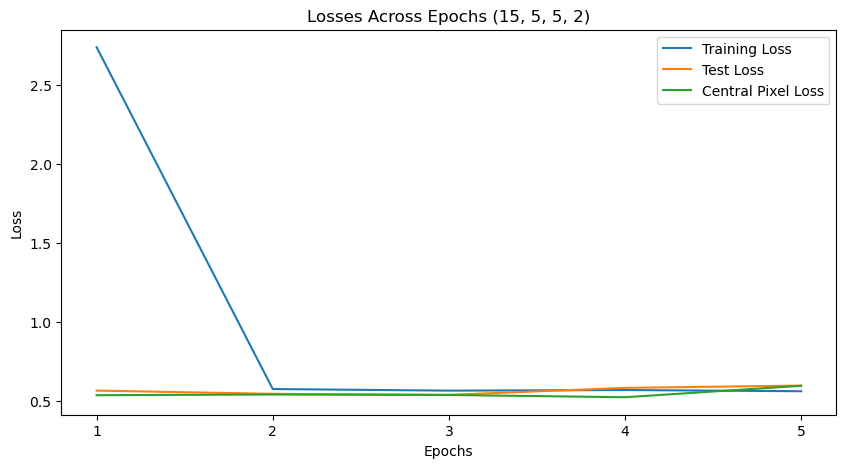

side = 18, kernel_size1 = 3, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 1.5913, test MSE: 0.5840, central pixel MAE: 0.6042
Epoch 2/5, train MSE: 0.5669, test MSE: 0.5738, central pixel MAE: 0.5692
Epoch 3/5, train MSE: 0.5488, test MSE: 0.5469, central pixel MAE: 0.5689
Epoch 4/5, train MSE: 0.5433, test MSE: 0.5569, central pixel MAE: 0.5688
Epoch 5/5, train MSE: 0.5150, test MSE: 0.5168, central pixel MAE: 0.5415


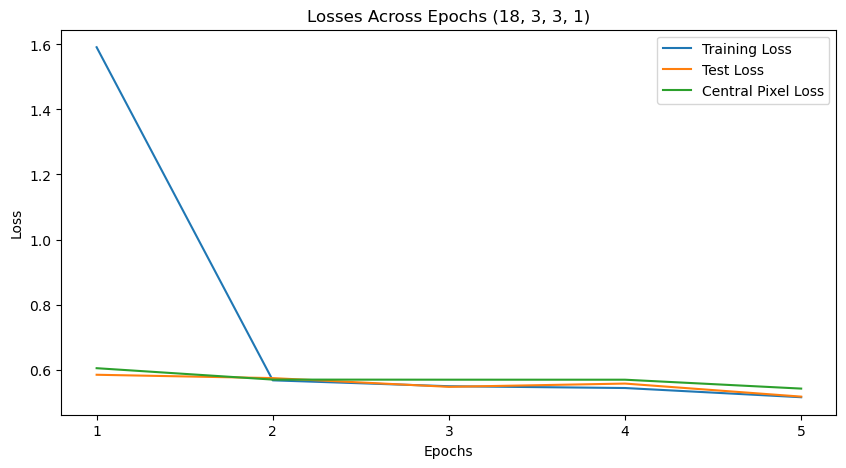

side = 18, kernel_size1 = 3, kernel_size2 = 3, stride = 2
Epoch 1/5, train MSE: 3.1024, test MSE: 0.5791, central pixel MAE: 0.5873
Epoch 2/5, train MSE: 0.5744, test MSE: 0.5464, central pixel MAE: 0.5569
Epoch 3/5, train MSE: 0.5669, test MSE: 0.5490, central pixel MAE: 0.5617
Epoch 4/5, train MSE: 0.5753, test MSE: 0.5367, central pixel MAE: 0.5217
Epoch 5/5, train MSE: 0.5679, test MSE: 0.5330, central pixel MAE: 0.5106


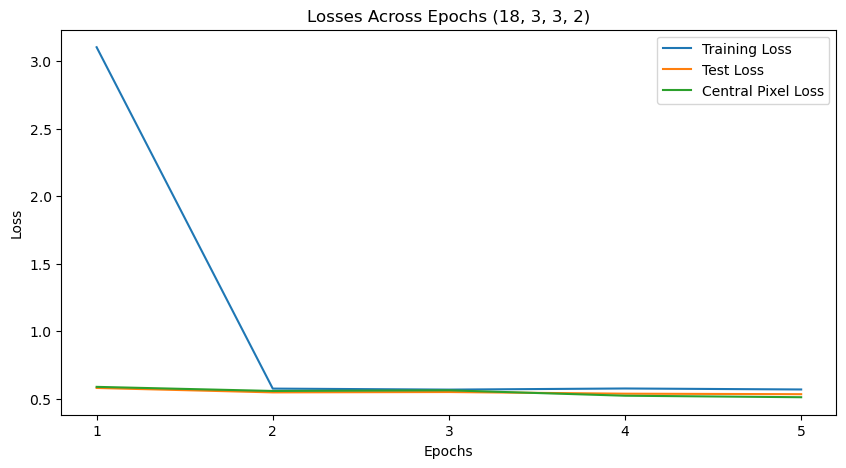

side = 18, kernel_size1 = 3, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.5743, test MSE: 0.5603, central pixel MAE: 0.5751
Epoch 2/5, train MSE: 0.5516, test MSE: 0.5309, central pixel MAE: 0.5481
Epoch 3/5, train MSE: 0.5468, test MSE: 0.5299, central pixel MAE: 0.5357
Epoch 4/5, train MSE: 0.5340, test MSE: 0.5570, central pixel MAE: 0.5366
Epoch 5/5, train MSE: 0.5311, test MSE: 0.5143, central pixel MAE: 0.5432


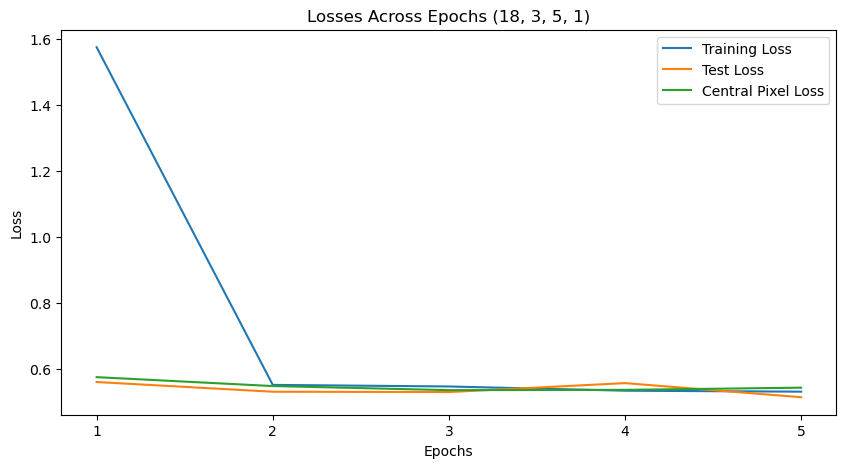

side = 18, kernel_size1 = 3, kernel_size2 = 5, stride = 2
Epoch 1/5, train MSE: 2.7574, test MSE: 0.5941, central pixel MAE: 0.5639
Epoch 2/5, train MSE: 0.5320, test MSE: 0.5766, central pixel MAE: 0.5315
Epoch 3/5, train MSE: 0.5326, test MSE: 0.5431, central pixel MAE: 0.5341
Epoch 4/5, train MSE: 0.5243, test MSE: 0.5476, central pixel MAE: 0.5468
Epoch 5/5, train MSE: 0.5312, test MSE: 0.5494, central pixel MAE: 0.5360


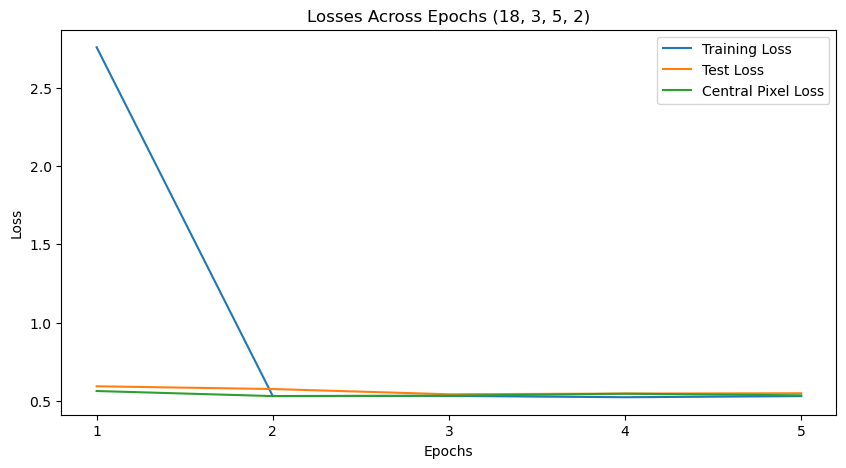

side = 18, kernel_size1 = 5, kernel_size2 = 3, stride = 1
Epoch 1/5, train MSE: 1.5482, test MSE: 0.6251, central pixel MAE: 0.5887
Epoch 2/5, train MSE: 0.5653, test MSE: 0.5861, central pixel MAE: 0.5743
Epoch 3/5, train MSE: 0.5465, test MSE: 0.5749, central pixel MAE: 0.5677
Epoch 4/5, train MSE: 0.5570, test MSE: 0.5608, central pixel MAE: 0.5443
Epoch 5/5, train MSE: 0.5339, test MSE: 0.5595, central pixel MAE: 0.5638


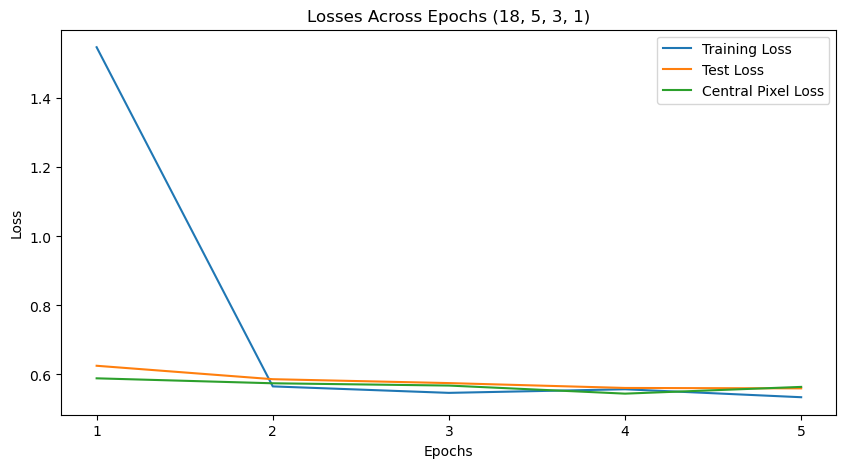

side = 18, kernel_size1 = 5, kernel_size2 = 3, stride = 2
Epoch 1/5, train MSE: 3.1379, test MSE: 0.5993, central pixel MAE: 0.6561
Epoch 2/5, train MSE: 0.5716, test MSE: 0.5555, central pixel MAE: 0.5497
Epoch 3/5, train MSE: 0.5599, test MSE: 0.5436, central pixel MAE: 0.5467
Epoch 4/5, train MSE: 0.5515, test MSE: 0.5518, central pixel MAE: 0.5442
Epoch 5/5, train MSE: 0.5510, test MSE: 0.5394, central pixel MAE: 0.5357


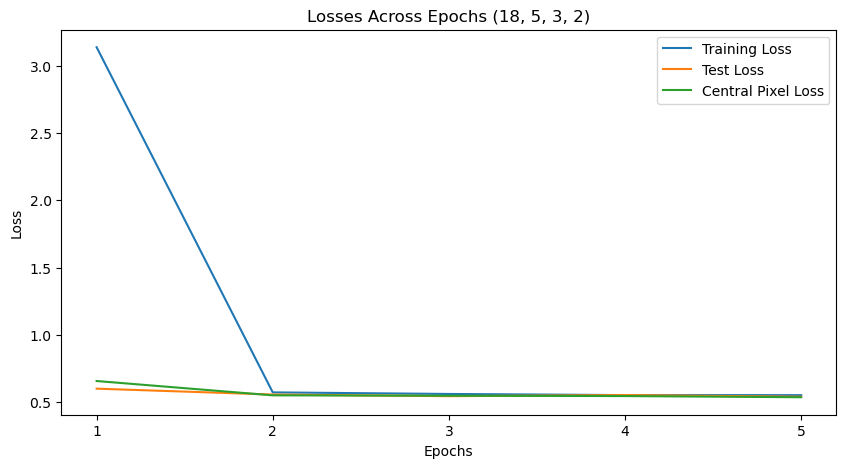

side = 18, kernel_size1 = 5, kernel_size2 = 5, stride = 1
Epoch 1/5, train MSE: 1.6671, test MSE: 0.5506, central pixel MAE: 0.5659
Epoch 2/5, train MSE: 0.5822, test MSE: 0.6311, central pixel MAE: 0.6006
Epoch 3/5, train MSE: 0.5701, test MSE: 0.5446, central pixel MAE: 0.5598
Epoch 4/5, train MSE: 0.5697, test MSE: 0.5016, central pixel MAE: 0.5196
Epoch 5/5, train MSE: 0.5116, test MSE: 0.5218, central pixel MAE: 0.5340


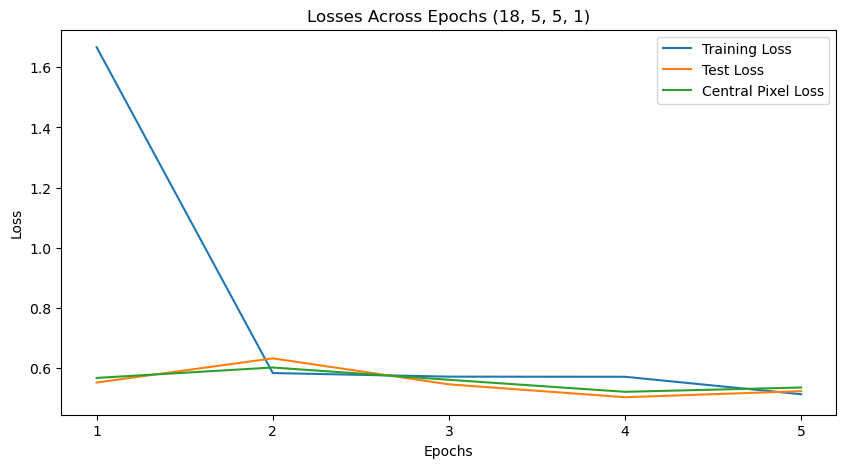

side = 18, kernel_size1 = 5, kernel_size2 = 5, stride = 2
Epoch 1/5, train MSE: 2.5304, test MSE: 0.5737, central pixel MAE: 0.6024
Epoch 2/5, train MSE: 0.5711, test MSE: 0.5435, central pixel MAE: 0.5220
Epoch 3/5, train MSE: 0.5509, test MSE: 0.5399, central pixel MAE: 0.5815
Epoch 4/5, train MSE: 0.5408, test MSE: 0.5089, central pixel MAE: 0.5478
Epoch 5/5, train MSE: 0.5328, test MSE: 0.4855, central pixel MAE: 0.5229


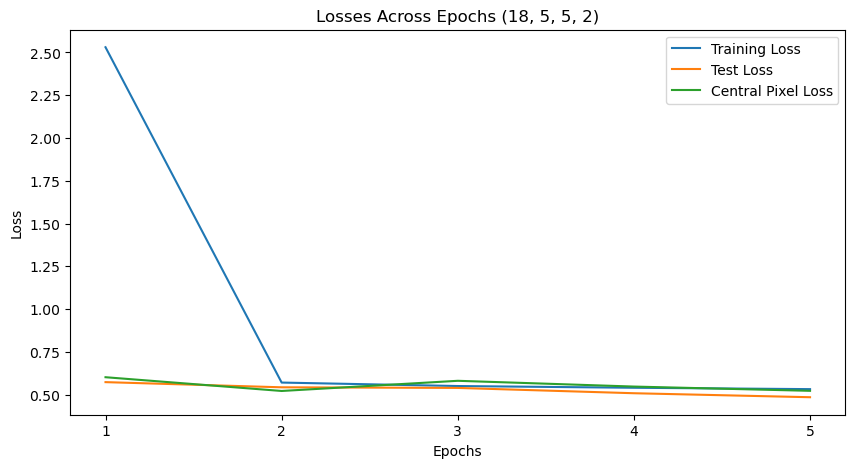

In [22]:
with open("errors.pkl", "rb") as file:
    errors = pickle.load(file)
    
for params in errors:
    side, kernel_size1, kernel_size2, stride = params
    err = errors[(side, kernel_size1, kernel_size2, stride)]
    print(f'side = {side}, kernel_size1 = {kernel_size1}, kernel_size2 = {kernel_size2}, stride = {stride}')
    epochs = len(err[0])
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}, train MSE: {err[0][epoch]:.4f}, \
test MSE: {err[1][epoch]:.4f}, central pixel MAE: {err[2][epoch]:.4f}')

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), err[0], label='Training Loss')
    plt.plot(range(1, epochs+1), err[1], label='Test Loss')
    plt.plot(range(1, epochs+1), err[2], label='Central Pixel Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Losses Across Epochs {params}')
    plt.legend()
    plt.xticks(range(1, epochs + 1))
    plt.show()

## Ranking best performing models

In [38]:
# Initialize lists to hold sorted values based on the user's criteria
list1 = []
list2 = []
list3 = []
list4 = []

# Process each key-value pair in the dictionary
for key, arrays in errors.items():
    test = arrays[1]
    central = arrays[2]
    list1.append((key, test[2]))
    list2.append((key, test[3]))
    list3.append((key, central[2]))
    list4.append((key, central[3]))

list1.sort(key=lambda x: x[1])  # Sort by the second element in each tuple in list1
list2.sort(key=lambda x: x[1])  # Sort by the second element in each tuple in list2
list3.sort(key=lambda x: x[1])  # Sort by the second element in each tuple in list3
list4.sort(key=lambda x: x[1])  # Sort by the second element in each tuple in list4

print('Test Error at epoch=3', list1[:3])
print('Test Error at epoch=4', list2[:3])
print('Central Error at epoch=3', list3[:3])
print('Central Error at epoch=4', list4[:3])

Test Error at epoch=3 [((12, 5, 5, 1), 0.4985216959164693), ((15, 3, 5, 2), 0.5118838531466631), ((12, 3, 5, 1), 0.5120593160390854)]
Test Error at epoch=4 [((15, 3, 5, 1), 0.4826699667252027), ((12, 5, 5, 1), 0.4913940590161543), ((18, 5, 5, 1), 0.5016376966467271)]
Central Error at epoch=3 [((12, 5, 5, 1), 0.49680011375592303), ((9, 3, 3, 1), 0.503926660005863), ((12, 3, 5, 1), 0.5229193889177763)]
Central Error at epoch=4 [((12, 3, 3, 1), 0.5021717181572547), ((15, 3, 5, 2), 0.5146674892077079), ((12, 5, 5, 1), 0.5153872897991768)]


## Best model (12, 5, 5, 1) results

In [40]:
# Chosen parameters
n = 200
sides = 12
kernel_sizes1 = 5
kernel_sizes2 = 5
strides = 1
epochs = 3

X, Y = make_data(n, side)
train_loader, test_loader = Train_test_split(X, Y)
model = MangroveHeightCNN(kernel_size1, kernel_size2, stride, side)
criterion = nn.MSELoss()  # for regression task
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses, central_pixel_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

/var/folders/nc/tqchq1n11vn9wtlb87_w4_340000gn/T/ipykernel_17475/662057009.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor([sample[0] for sample in mangrove_data], dtype=torch.float32)


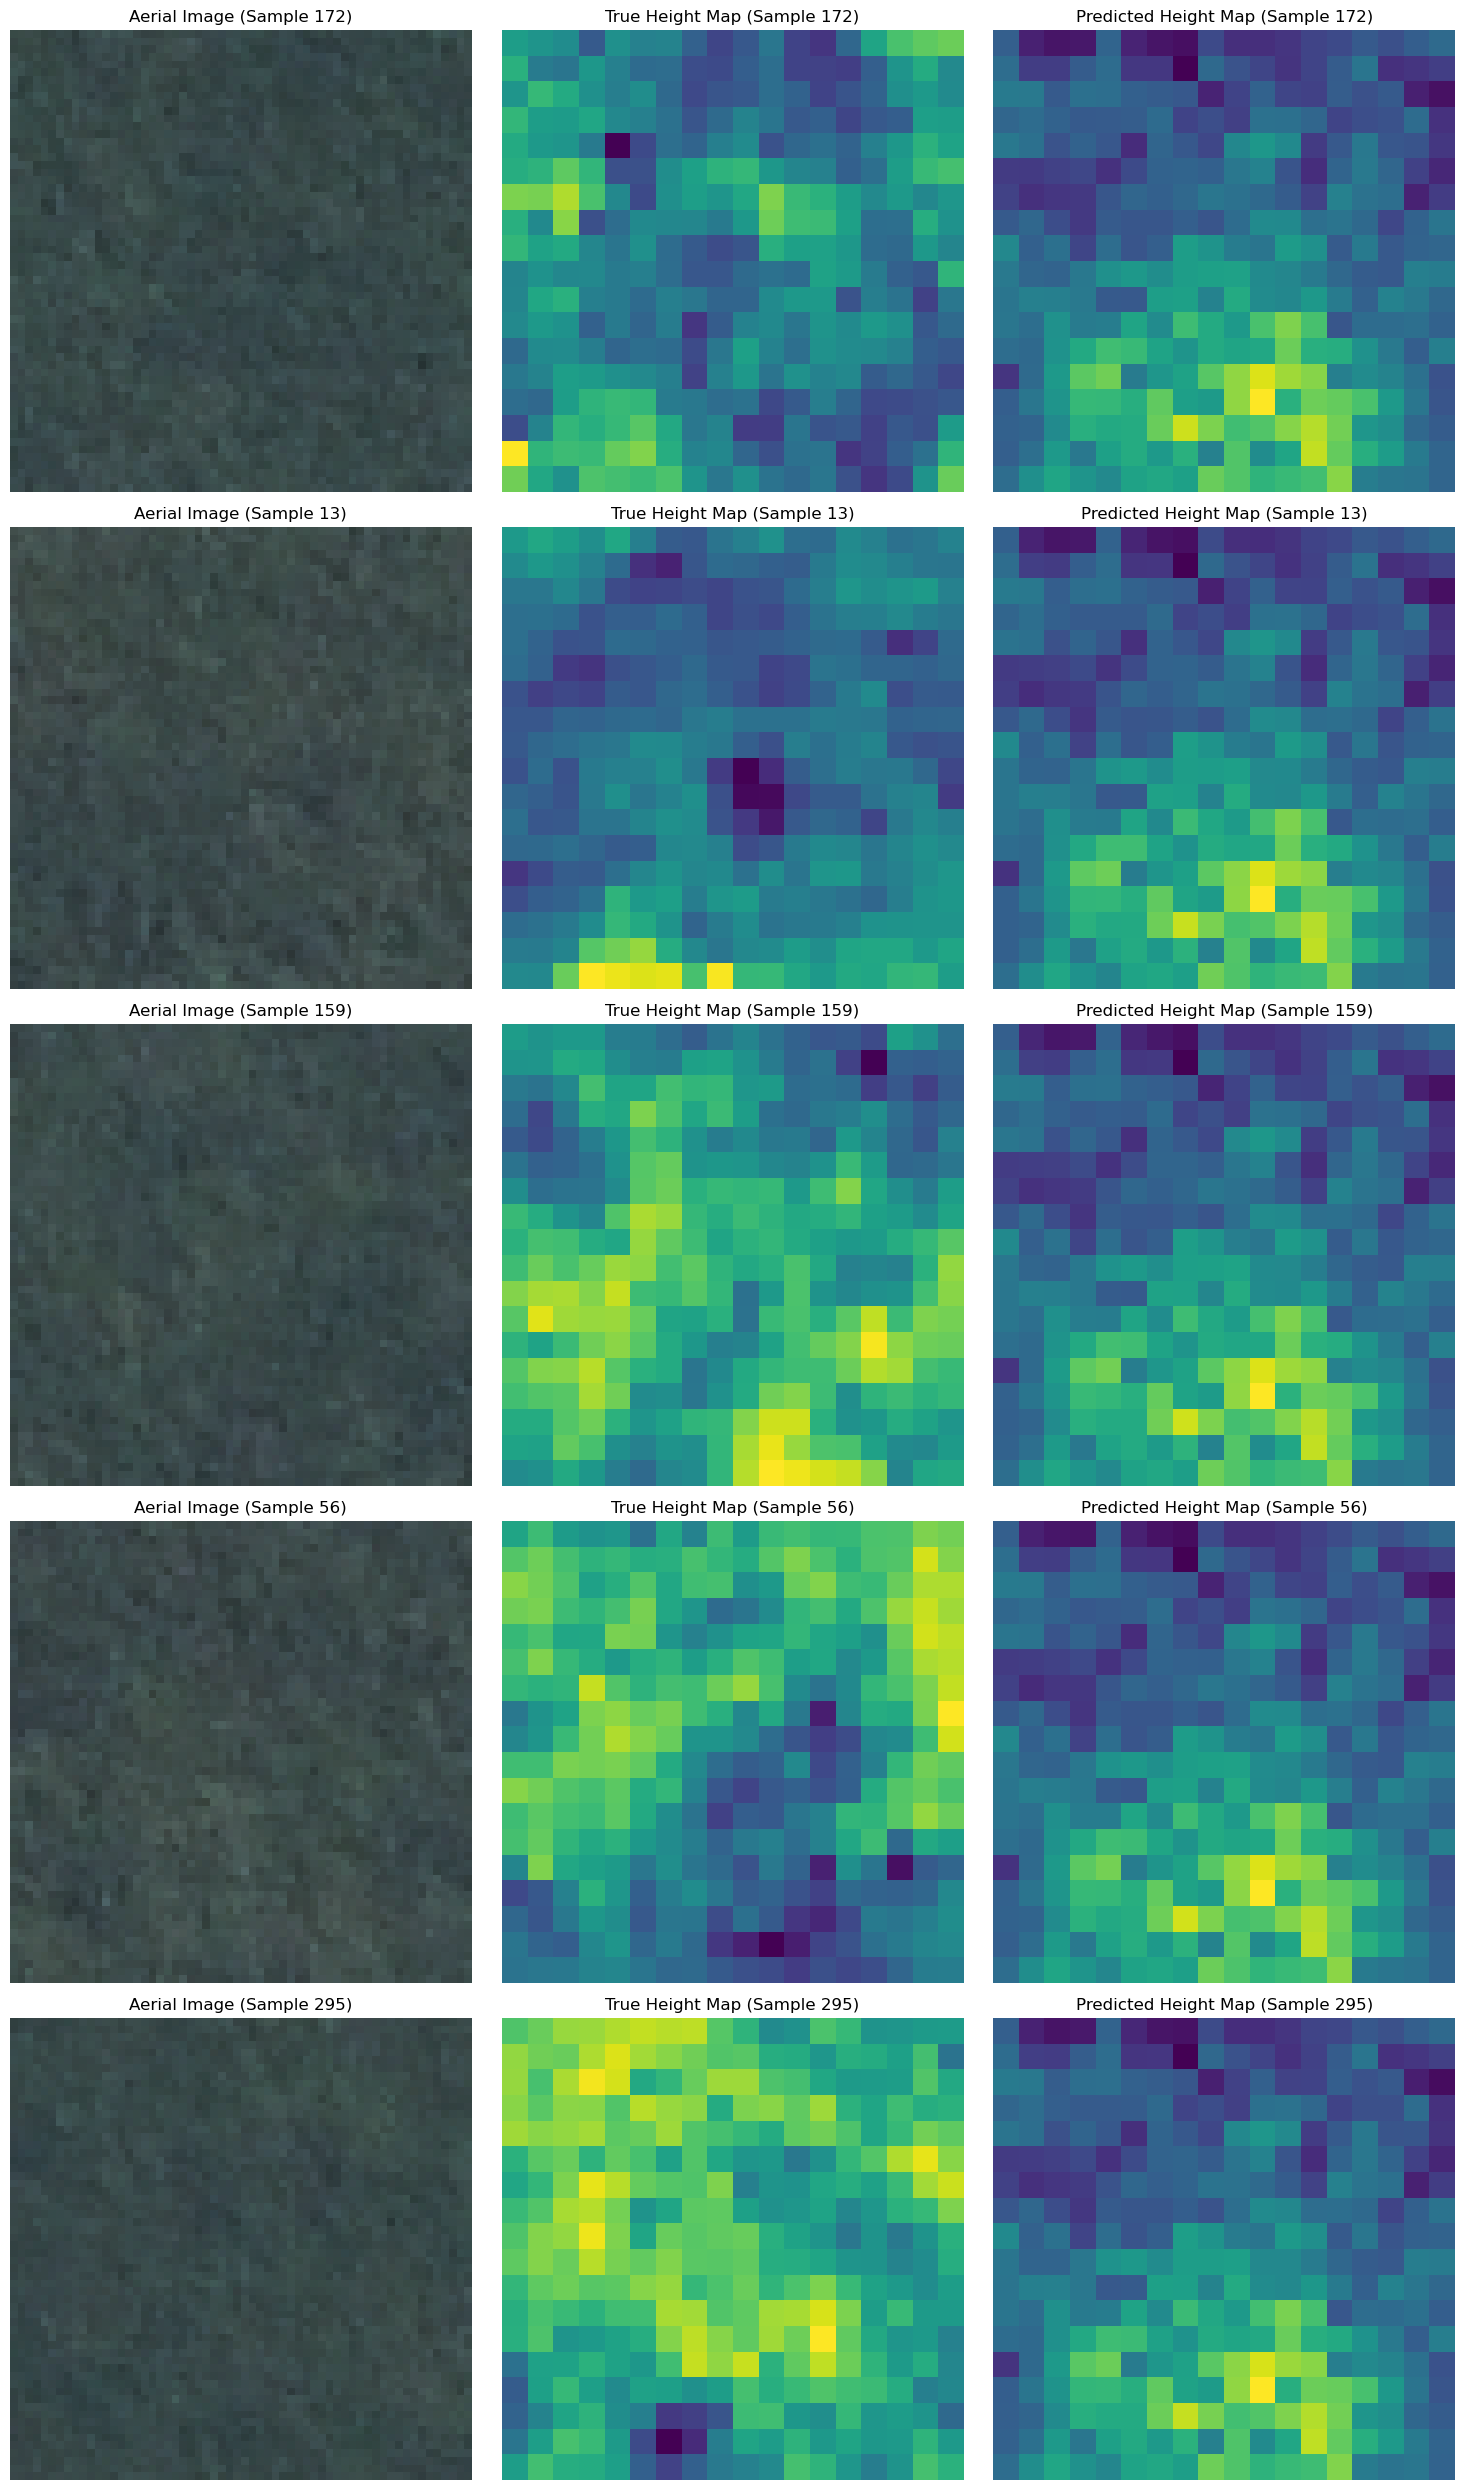

In [44]:
# Function to visualize the predictions
def visualize_predictions(model, test_loader, num_samples):
    model.eval()  # Set model to evaluation mode

    # Randomly select indices
    indices = random.sample(range(len(test_loader.dataset)), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        # Get the sample from the test loader
        aerial_image, true_height_map = test_loader.dataset[idx]
        aerial_image = aerial_image.unsqueeze(0)  # Add batch dimension for prediction (1, 4, 30, 30)
        
        # Predict height map using the model
        with torch.no_grad():
            predicted_height_map = model(aerial_image)  # Predicts (1, 1, 9, 9)
        
        # Prepare data for plotting
        true_height_map = true_height_map.squeeze(0).numpy()  # (9, 9)
        predicted_height_map = predicted_height_map.squeeze(0).squeeze(0).numpy()  # (9, 9) after squeezing out the channel dimension
        aerial_image = aerial_image.squeeze(0).permute(1, 2, 0).numpy()  # (30, 30, 4)
        
        # Plotting
        axs[i, 0].imshow(aerial_image)  # Aerial image (30x30)
        axs[i, 0].set_title(f'Aerial Image (Sample {idx})')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(true_height_map, cmap='viridis')  # True height map (9x9)
        axs[i, 1].set_title(f'True Height Map (Sample {idx})')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predicted_height_map, cmap='viridis')  # Predicted height map (9x9)
        axs[i, 2].set_title(f'Predicted Height Map (Sample {idx})')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, test_loader, num_samples=5)

## Baseline ANN

Epoch 1/10, train MSE: 1.4572, test MSE: 0.6710, central pixel MAE: 0.6387
Epoch 2/10, train MSE: 0.6628, test MSE: 0.6783, central pixel MAE: 0.6236
Epoch 3/10, train MSE: 0.6571, test MSE: 0.6991, central pixel MAE: 0.6272
Epoch 4/10, train MSE: 0.6183, test MSE: 0.6660, central pixel MAE: 0.6159
Epoch 5/10, train MSE: 0.5896, test MSE: 0.6386, central pixel MAE: 0.6254
Epoch 6/10, train MSE: 0.5753, test MSE: 0.6269, central pixel MAE: 0.6240
Epoch 7/10, train MSE: 0.5539, test MSE: 0.6356, central pixel MAE: 0.5843
Epoch 8/10, train MSE: 0.5459, test MSE: 0.5595, central pixel MAE: 0.5760
Epoch 9/10, train MSE: 0.5296, test MSE: 0.5663, central pixel MAE: 0.5358
Epoch 10/10, train MSE: 0.5027, test MSE: 0.5497, central pixel MAE: 0.5160


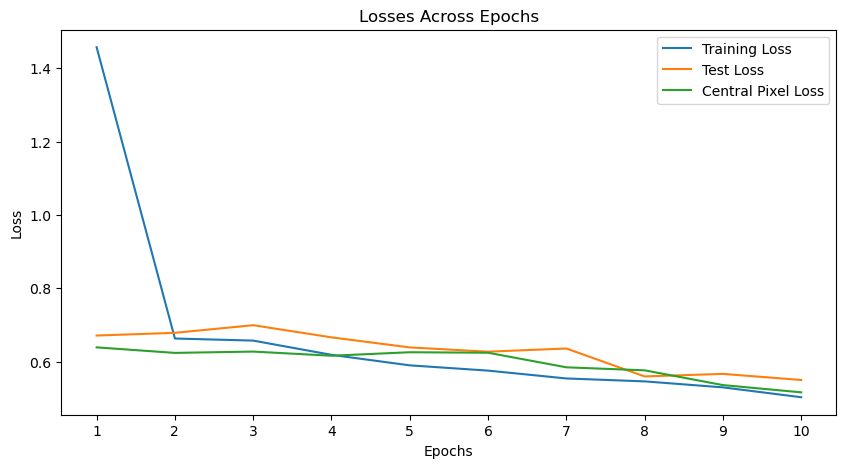

In [32]:
def make_data1(n, side): 
    # num of random crops, side len in m=px of height image cropped
    mangrove_data = []
    pixel_side = int(side/0.3)  # side length in pixels for aerial image crop
    flattened_dim_x = pixel_side * pixel_side * 3  # 3 channels
    flattened_dim_y = side * side  # output height image flattened to vector

    for base_name in Height:
        x_lim = Height[base_name][0].shape[1] - side
        y_lim = Height[base_name][0].shape[0] - side
        
        for i in range(n):
            # Sometimes random point falls outside the boundary because aerial photo doesn't cover all DEM-DSM image
            while True:
                try:
                    x = random.randint(0, x_lim)
                    y = random.randint(0, y_lim)
                    Height_window, aer_window = overlap(base_name, x, y, side)
                    break
                except:
                    pass
            aer_crop = crop(aer_data[0], aer_window)[:3]  # Only use first 3 channels (RGB)
            hei_crop = crop(Height[base_name][0], Height_window)
            mangrove_data.append([aer_crop, hei_crop])

    X = torch.tensor([sample[0] for sample in mangrove_data], dtype=torch.float32)[:, :3, :, :] / 255.0  # Normalize
    X = X.view(X.size(0), -1)  # Flatten to 4800-dimensional vector
    Y = torch.tensor([sample[1] for sample in mangrove_data], dtype=torch.float32)
    Y = Y.view(Y.size(0), -1)  # Flatten height output to 144-dimensional vector
    return X, Y

class MangroveHeightANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MangroveHeightANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train_model1(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    train_losses = []
    test_losses = []
    central_pixel_losses = []
    central_pixel_index = side*side//2 
    
    for epoch in range(epochs):
        # Training
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Test
        model.eval()  # Set model to evaluation mode
        running_test_loss = 0.0
        running_central_pixel_loss = 0.0
        
        with torch.no_grad():  # No gradient computation in evaluation mode
            for test_inputs, test_targets in test_loader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_targets)
                running_test_loss += test_loss.item()

                # For central pixel loss, we compare the flattened vector at index 72
                predicted_central_pixel = test_outputs[:, central_pixel_index]
                target_central_pixel = test_targets[:, central_pixel_index]
                central_pixel_loss = torch.abs(predicted_central_pixel - target_central_pixel).mean().item()
                running_central_pixel_loss += central_pixel_loss

        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        avg_central_pixel_loss = running_central_pixel_loss / len(test_loader)
        central_pixel_losses.append(avg_central_pixel_loss)
    
    return np.array(train_losses), np.array(test_losses), np.array(central_pixel_losses)

# Hyperparameters
n = 200
side = 12  # Side length of aerial image in meters
input_dim = 40 * 40 * 3  # Flattened 40x40x3 image for ANN
output_dim = side * side  # Flattened 12x12 height image
repeat = 4 # to average for each model setting
epochs = 10

errors = [[],[],[]]
for j in range(repeat):
    X, Y = make_data1(n, side)
    train_loader, test_loader = Train_test_split(X, Y)
    model = MangroveHeightANN(input_dim, output_dim)
    criterion = nn.MSELoss()  # For regression task
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_losses, central_pixel_losses = train_model1(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)
    errors[0].append(train_losses)
    errors[1].append(test_losses)
    errors[2].append(central_pixel_losses)

errors[0] = np.mean(errors[0], axis=0)
errors[1] = np.mean(errors[1], axis=0)
errors[2] = np.mean(errors[2], axis=0)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}, train MSE: {errors[0][epoch]:.4f}, \
test MSE: {errors[1][epoch]:.4f}, central pixel MAE: {errors[2][epoch]:.4f}')

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), errors[0], label='Training Loss')
plt.plot(range(1, epochs+1), errors[1], label='Test Loss')
plt.plot(range(1, epochs+1), errors[2], label='Central Pixel Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Losses Across Epochs')
plt.legend()
plt.xticks(range(1, epochs+1))
plt.show()